## Question 2 

Using PyTorch,
implement a version of the CNN network architecture that was discussed in class, to train and
test a handwritten digit recognition system. You can read the paper “Backpropagation Applied to
Handwritten Zip Code Recognition” by LeCun et al. 1989 for more details, but your architecture
will not follow exactly what was mentioned in the paper. Use the MNIST dataset to train and test
the system. Be sure to divide the data into a single training, validation and testing set. Note that
you do not need to resize the inputs to size 16 ×16.

The baseline system should use the following: Glorot initialization, ReLU activations, mini-batch
gradient descent with momentum (β = 0.9), early stopping and a cross-entropy loss function. Use
a learning rate scheduler to adjust the learning rate by 10% every 10 epochs, starting with a learn-
ing rate of 0.05. You are encouraged to use UITS Carbonate Deep Learning cluster to
develop your system, since they have GPUs which will improve the training process.
Generate learning curves for the validation and training set. Discuss whether this baseline system
overfits, underfits or reasonably fits the validation data. Test this baseline system with the testing
data and report the accuracy and show a confusion matrix. Submit your solution to this part
of the problem in a Jupyter notebook document named: baseline.ipynb.


### Baseline system

#### Architecture

- Layers
    - input layer - image (original / scaled)
    
    - convolution
    
        -            feature maps
        
        -                kernal (#glorot initialization)
        
        -                sliding
        
    - pooling
    
        -                  max pooling
    
    - repeat until flatten
    
    - feed forward
           

## Incorporate batch normalization before each convolutional hidden layer.

In [6]:
# imports as needed for the baseline system

import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split, Subset
from torch.utils.data import DataLoader as dl
from torch import optim
from torch.optim.lr_scheduler import StepLR
from torch.autograd import Variable
from sklearn.metrics import confusion_matrix
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sn
import copy

In [7]:
# This/These cell(s) is responsible for the below mentioned part of the problem statement.

# Use the MNIST dataset to train and test the system. 
# Be sure to divide the data into a single training, validation and testing set. 
# Note that you do not need to resize the inputs to size 16 ×16.

transforms = transforms.Compose([transforms.ToTensor()])
training_data = datasets.MNIST(root = 'data', train = True, transform = transforms, download = True)
train_ind, valid_ind = random_split(training_data, [50000,10000])
train_data = Subset(training_data, train_ind.indices)
valid_data = Subset(training_data, valid_ind.indices)
test_data = datasets.MNIST(root = 'data', train = False, transform = transforms)

In [8]:
print(train_data, len(train_data))
print(valid_data, len(valid_data))
print(test_data, len(test_data))

<torch.utils.data.dataset.Subset object at 0x7f78302eb1f0> 50000
<torch.utils.data.dataset.Subset object at 0x7f78302eb2b0> 10000
Dataset MNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
           ) 10000


In [4]:
loaders = {}
loaders['train'] =  dl(train_data, batch_size = 50, shuffle = False, num_workers=4)
loaders['valid'] = dl(valid_data, batch_size = 50, shuffle = False, num_workers=4)
loaders['test'] = dl(test_data, batch_size = 50, shuffle = False, num_workers=4)

loaders

{'train': <torch.utils.data.dataloader.DataLoader at 0x7fc62cc7a400>,
 'valid': <torch.utils.data.dataloader.DataLoader at 0x7fc62cc7a460>,
 'test': <torch.utils.data.dataloader.DataLoader at 0x7fc62cc7aca0>}

In [5]:
### Critical for the baseline 
### Model architecture turned to code
### Layers detailed above

### Key implementations in this cell:
### Glorot initialization as xavier_uniform
### RELU Activation
### Convolutions and Pooling

class CNN(nn.Module):
    def __init__(self):
    
        # initializing the parent object
        super(CNN, self).__init__()
        
        # creating the first convolution layer
        conv_layer1 = nn.Conv2d(1, 32, 5, 1, 2) #in-size, out-size, kernel-size, stride = 1, padding = 2              
        # initializing it as per the assignment: Glorot Initialization ~ xavier_uniform
        nn.init.xavier_uniform_(conv_layer1.weight)

        # only required to perform in a series of steps, only cursory
        self.conv1 = nn.Sequential(         
            # passing the conv layer variable created above
            conv_layer1,      
            nn.BatchNorm2d(32),
            # relu layer, as per assignment, however, activation can be different
            nn.ReLU(),                      
            # taking the generated output from the previous convolution(s) and pooling them 
            # here, it is a max pooling, that is taking the max output from the convolution filter.
            nn.MaxPool2d(2),    
        )

        conv_layer2 = nn.Conv2d(32, 64, 5, 1, 2)
        nn.init.xavier_uniform_(conv_layer2.weight)
        self.conv2 = nn.Sequential(         
            conv_layer2,    
            nn.BatchNorm2d(64),
            nn.ReLU(),                      
            nn.MaxPool2d(2),                
        )
        
        # fully connected layer, output 10 classes
        
        dnn1_layer = nn.Linear(64 * 7 * 7, 32)
        self.dnn1 = nn.Sequential(         
            dnn1_layer,    
            nn.BatchNorm1d(32),
            nn.ReLU(),                                   
        )
        self.out = nn.Linear(32, 10)
        
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        # flatten the output of conv2 to (batch_size, 32 * 7 * 7)
        x = x.view(x.size(0), -1)  
        x = self.dnn1(x)
        output = self.out(x)
        return output, x    # return x for visualization

In [6]:
cnn = CNN()
print(cnn)

CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (dnn1): Sequential(
    (0): Linear(in_features=3136, out_features=32, bias=True)
    (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (out): Linear(in_features=32, out_features=10, bias=True)
)


In [7]:
# cross entropy function as mentioned in the problem statement
loss_func = nn.CrossEntropyLoss()   
loss_func

CrossEntropyLoss()

In [8]:
# as mentioned in the problem statement, 
# we are taking the SGD optimizer for performing 
# Mini Batch Gradient Descent with momentum

optimizer = optim.SGD(cnn.parameters(), lr = 0.05, momentum = 0.9)   
optimizer
scheduler = StepLR(optimizer, step_size = 10000, gamma = 0.9)
print(optimizer.param_groups[0]['lr'])

0.05


In [9]:
# Key points from this cell:
# Early Stopping
# Training
# Validation
# Learning Rate as per epoch

num_epochs = 35
loss_tracker = []
epoch_tracker = []
valid_accuracy_tracker = []
valid_loss_tracker =[]

patience = 3
min_delta = 0.001
best_loss = None
counter = 0
same_min_delta = 0 
no_epochs = 0
best_model = None


def early_stopping_func(val_loss):
    global best_loss
    global patience
    global counter
    global min_delta
    #print(best_loss,val_loss,abs(best_loss - val_loss))
    if best_loss == None:
        best_loss = val_loss
    elif best_loss - val_loss > min_delta:
        best_loss = val_loss
        # reset counter if validation loss improves
        counter = 0
    elif best_loss - val_loss < min_delta:
        counter += 1
        print(f"INFO: Early stopping counter {counter} of {patience}")
        if counter >= patience:            
            print('INFO: Early stopping')
            return  True
        return False

    
def train(num_epochs, cnn, loaders):
    
    #early_stopping = EarlyStopping(patience=patience, verbose=True)
    global no_epochs
    cnn.train()
    # Train the model
    total_step = len(loaders['train'])
    for epoch in range(num_epochs):
        #############################
        ###### Training the model####
        #############################
        epoch_loss_tracker = []
        if epoch % 10 == 0:
            print(optimizer.param_groups[0]['lr'])
        for _, (images, labels) in enumerate(loaders['train']):
            #print(optimizer.param_groups[0]['lr'])
            # gives batch data, normalize x when iterate train_loader
            image_data = Variable(images) 
            label_data = Variable(labels) 
            output = cnn(image_data)[0]
            loss = loss_func(output, label_data)
            
            # clear gradients for this training step   
            optimizer.zero_grad()           
            # backpropagation, compute gradients 
            loss.backward()    
            # apply gradients             
            optimizer.step() 
            scheduler.step()
            if (_+1) % 50 == 0:
                print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch + 1, num_epochs, _ + 1, total_step, loss.item()))
            epoch_loss_tracker.append(loss)  
        loss_tracker.append(sum(epoch_loss_tracker)/1000)
        epoch_tracker.append(epoch)
        
        ##################################
        ###### Fitting on validation #####
        ##################################
        
        
        cnn.eval()
        valid_loss_batch = []
        with torch.no_grad():
            correct = 0
            total = 0
            for images, labels in loaders['valid']:
            
                image_data = Variable(images) 
                label_data = Variable(labels) 
                valid_output, last_layer = cnn(images)
                loss = loss_func(valid_output, label_data)
                valid_loss_batch.append(loss)

                valid_pred_y = torch.max(valid_output, 1)[1].data.squeeze()
                accuracy = (valid_pred_y == labels).sum().item() / float(labels.size(0))
                valid_accuracy_tracker.append(accuracy)
        print('Validation Accuracy of the model on the 10000 validation images: %.2f' % accuracy)
        
        valid_loss = np.average(np.array(valid_loss_batch))
        valid_loss_tracker.append(valid_loss)
        
        print(valid_loss)
        
        global best_model 
        if early_stopping_func(valid_loss):
            print("Early stopping")
            best_model = copy.deepcopy(cnn)
        
train(num_epochs, cnn, loaders)

0.05
Epoch [1/35], Step [50/1000], Loss: 0.2957
Epoch [1/35], Step [100/1000], Loss: 0.0615
Epoch [1/35], Step [150/1000], Loss: 0.0701
Epoch [1/35], Step [200/1000], Loss: 0.2893
Epoch [1/35], Step [250/1000], Loss: 0.0127
Epoch [1/35], Step [300/1000], Loss: 0.0212
Epoch [1/35], Step [350/1000], Loss: 0.1209
Epoch [1/35], Step [400/1000], Loss: 0.0918
Epoch [1/35], Step [450/1000], Loss: 0.0101
Epoch [1/35], Step [500/1000], Loss: 0.0407
Epoch [1/35], Step [550/1000], Loss: 0.3081
Epoch [1/35], Step [600/1000], Loss: 0.0114
Epoch [1/35], Step [650/1000], Loss: 0.1159
Epoch [1/35], Step [700/1000], Loss: 0.0672
Epoch [1/35], Step [750/1000], Loss: 0.0506
Epoch [1/35], Step [800/1000], Loss: 0.0305
Epoch [1/35], Step [850/1000], Loss: 0.0268
Epoch [1/35], Step [900/1000], Loss: 0.0851
Epoch [1/35], Step [950/1000], Loss: 0.2922
Epoch [1/35], Step [1000/1000], Loss: 0.1214
Validation Accuracy of the model on the 10000 validation images: 1.00
0.041539878
Epoch [2/35], Step [50/1000], Los

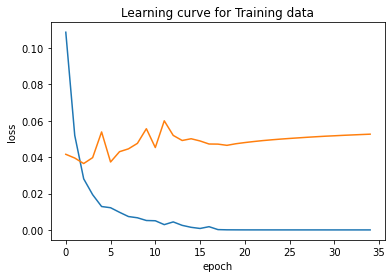

In [10]:
# Learning curves

# Loss vs Epoch
# for validation and training

loss = [i.data.item() for i in loss_tracker]
valid_loss = [i for i in valid_loss_tracker]
plt.title("Learning curve for Training data")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.plot(np.arange(0,num_epochs),np.array(loss), label = "Training Loss")
plt.plot(np.arange(0,num_epochs),np.array(valid_loss), label = "Validation Loss")

In [20]:
if best_model != None:
    print(best_model)
    cnn = copy.deepcopy(best_model)

CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (dnn1): Sequential(
    (0): Linear(in_features=3136, out_features=32, bias=True)
    (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (out): Linear(in_features=32, out_features=10, bias=True)
)


In [21]:
# Training Accuracy
# Added as a part of reconcilation and validation of the model

training_accuracy_tracker = []

def test_on_training():
    # Test the validation model
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in loaders['train']:
            image_data = Variable(images) 
            label_data = Variable(labels) 
            training_output, last_layer = cnn(images)
            
            training_pred_y = torch.max(training_output, 1)[1].data.squeeze()
            accuracy = (training_pred_y == labels).sum().item() / float(labels.size(0))
            training_accuracy_tracker.append(accuracy)
    print('Training Accuracy of the model on the 50000 Training images: %.2f' % accuracy)
test_on_training()

Training Accuracy of the model on the 50000 Training images: 1.00


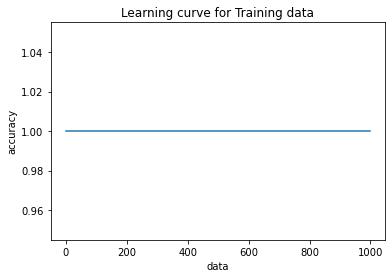

In [13]:
# Plotting Training Accuracy
# Added as a part of reconcilation and validation of the model


plt.title("Learning curve for Training data")
plt.xlabel("data")
plt.ylabel("accuracy")
plt.plot(np.arange(0,len(loaders['train'])),np.array(training_accuracy_tracker))

In [14]:
# Validation Accuracy
# Added as a part of reconcilation and validation of the model

valid_accuracy_tracker = []
valid_loss_tracker =[]


def valid():
    # Test the validation model
    cnn.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in loaders['valid']:
            image_data = Variable(images) 
            label_data = Variable(labels) 
            valid_output, last_layer = cnn(images)
            loss = loss_func(valid_output, label_data)
            valid_loss_tracker.append(loss)
            
            valid_pred_y = torch.max(valid_output, 1)[1].data.squeeze()
            accuracy = (valid_pred_y == labels).sum().item() / float(labels.size(0))
            valid_accuracy_tracker.append(accuracy)
    print('Validation Accuracy of the model on the 10000 validation images: %.2f' % accuracy)
valid()

Validation Accuracy of the model on the 10000 validation images: 0.98


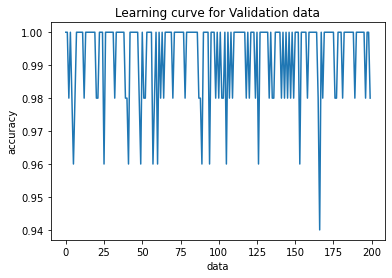

In [15]:
# Plotting Validation Accuracy
# Added as a part of reconcilation and validation of the model

plt.title("Learning curve for Validation data")
plt.xlabel("data")
plt.ylabel("accuracy")
plt.plot(np.arange(0,len(loaders['valid'])),np.array(valid_accuracy_tracker))

In [16]:
# Testing Accuracy
# Added as a part of reconcilation and validation of the model

test_labels = []
test_pred = []
test_accuracy_tracker = []
def test():
    # Test the model
    cnn.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in loaders['test']:
            #print(labels)
            test_labels.append(labels)
            test_output, last_layer = cnn(images)
            pred_y = torch.max(test_output, 1)[1].data.squeeze()
            test_pred.append(pred_y)
            accuracy = (pred_y == labels).sum().item() / float(labels.size(0))
            test_accuracy_tracker.append(accuracy)
    print('Test Accuracy of the model on the 10000 test images: %.2f' % accuracy)

test()

test_actual = []
[test_actual.extend(i.tolist()) for i in test_labels]

test_pred_orig = []

[test_pred_orig.extend(i.tolist()) for i in test_pred]

print(len(test_pred_orig),len(test_actual))

Test Accuracy of the model on the 10000 test images: 1.00
10000 10000


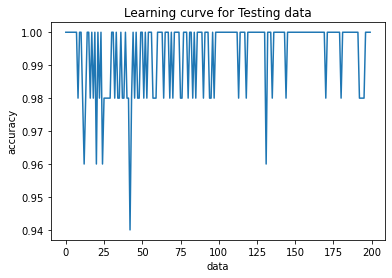

In [17]:
# Testing Accuracy
# Added as a part of reconcilation and validation of the model


plt.title("Learning curve for Testing data")
plt.xlabel("data")
plt.ylabel("accuracy")
plt.plot(np.arange(0,len(loaders['test'])),np.array(test_accuracy_tracker))

[[ 977    0    0    0    0    0    2    0    2    1]
 [   0 1132    0    0    0    0    2    2    1    0]
 [   0    0 1026    0    0    0    0    2    0    0]
 [   0    1    2 1009    0    5    1    0    1    0]
 [   0    0    0    0  977    0    1    0    0    4]
 [   0    0    0    1    0  886    2    0    0    4]
 [   2    1    1    0    1    1  949    0    0    0]
 [   1    0    3    0    0    0    0 1018    0    1]
 [   0    1    0    0    0    0    1    1  969    2]
 [   0    0    0    0    4    0    0    5    1  997]]


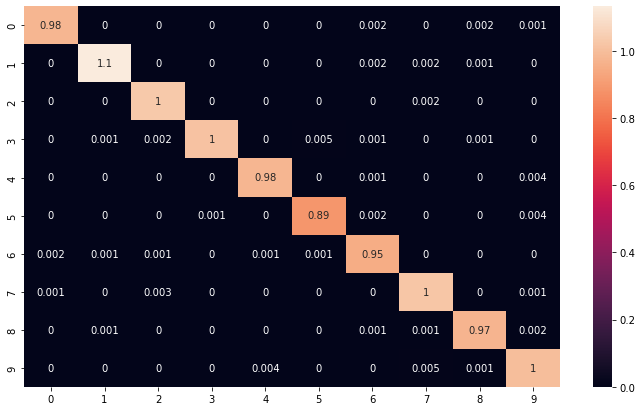

In [18]:
# creating confusion matrix as mentioned in the problem statement

cm = confusion_matrix(test_pred_orig,test_actual)
print(cm)
#producing a scaled version of the confusion matrix
df_cm = pd.DataFrame(cm/np.sum(cm) * 10, index = [i for i in range(10)],
                     columns = [i for i in range(10)])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)
plt.savefig('output.png')